# Importing Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import math as m
import numpy as np
import matplotlib.pyplot as plt

# Building of Activation functions



In [ ]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def softmax(Z):
    Z_exp = np.exp(Z - np.max(Z)) 
    Z_sum = np.sum(Z_exp,axis = 0, keepdims = True)
    return Z_exp/Z_sum

def relu_backward(dA, rel):
    #Implement the backward propagation for a single RELU unit.#
    Z = rel
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, sig):
    #Implement the backward propagation for a single SIGMOID unit#
    Z = sig
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ


In [ ]:
def ParametersIntialising_Layers(dimLayer):
    np.random.seed(3)
    parameters = {}
    L = len(dimLayer)            
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(dimLayer[l],dimLayer[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((dimLayer[l],1))    
    return parameters

# Forward Propogation



In [ ]:
class forwardpropagation:

    def activationforward(self,Pre_act, weights, bias, activation):
            #Implement the forward propagation for the LINEAR->ACTIVATION layer#
            # here we are implementing the basic sigmoid , relu and softmax activation layers
            if activation == "sigmoid":
                Z = np.dot(weights,Pre_act) + bias
                A = sigmoid(Z)
            elif activation == "relu":
                Z = np.dot(weights,Pre_act) + bias
                A = relu(Z)               
            elif activation == "softmax":
                Z = np.dot(weights,Pre_act) + bias
                A = softmax(Z)           
            return A

    def modelforward(self,X,activation_functions, param):
            #Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation#
            caches = []
            A = X
            L = len(param) // 2         #number of layers in nn      

            for l in range(1, L):
                A_prev = A 
                A =self.activationforward(A_prev,param['W' + str(l)],param['b' + str(l)],activation_functions[l-1])
                caches.append(((A_prev,param['W' + str(l)],param['b' + str(l)]),np.dot(param['W' + str(l)],A_prev) + param['b' + str(l)]))
            AL = self.activationforward(A,param['W' + str(L)],param['b' + str(L)],'softmax')
            caches.append(((A,param['W' + str(L)],param['b' + str(L)]),np.dot(param['W' + str(L)],A) + param['b' + str(L)]))           
            return AL, caches

In [ ]:
def compute_cost(AL, Y):    
    m = Y.shape[1]   
    cost = -(1/m)*(np.sum(np.multiply(Y,np.log(AL))) + np.sum(np.multiply(1 - Y,np.log(1 - AL))))   
    cost = np.squeeze(cost)         
    return cost

# Back Propogation




In [ ]:
class backwardPropagation:
        def backward(self, dZ, cache):           
            Pre_act, weights, bias = cache
            m = Pre_act.shape[1]
            dW = (1/m)*(np.dot(dZ,Pre_act.T))
            db = (1/m)*(np.sum(dZ,axis = 1,keepdims = True))
            dA_prev = np.dot(weights.T,dZ)
            return dA_prev, dW, db
        def activationBackward(self,dA, cache, activation):           
            linear_cache, activation_cache = cache
            if activation == "relu":
                dZ = relu_backward(dA, activation_cache)
                dA_prev, dW, db = self.backward(dZ,linear_cache)
            elif activation == "sigmoid":
                dZ = sigmoid_backward(dA,activation_cache)
                dA_prev, dW, db = self.backward(dZ,linear_cache)
            return dA_prev, dW, db

        def backwardModel(self,output_FP, Y,activation_functions, caches):
            grads = {}
            L = len(caches) # the number of layers
            m = output_FP.shape[1]
            Y = Y.reshape(output_FP.shape) # after this line, Y is the same shape as AL
            
            current_cache = caches[-1]
            linear_cache, activation_cache = current_cache
            dZ = output_FP - Y
            A_prev, W, b = linear_cache
            # Use the expressions you have used in 'layer_backward'
            grads["dA" + str(L-1)] = np.dot(W.T,dZ) #write your code here
            grads["dW" + str(L)] = (1./m)*np.dot(dZ,A_prev.T) #write your code here, use (1./m) and not (1/m)
            grads["db" + str(L)] = (1./m)*np.sum(dZ,axis=-1,keepdims=True) #write your code here, use (1./m) and not (1/m)
       
                    
            
            for l in reversed(range(L-1)):

                current_cache = caches[l]
                dA_prev_temp, dW_temp, db_temp = self.activationBackward(grads["dA" + str(l+1)],current_cache,activation_functions[l])
                grads["dA" + str(l)] = dA_prev_temp
                grads["dW" + str(l + 1)] = dW_temp
                grads["db" + str(l + 1)] = db_temp


            return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

In [ ]:
def initialization_adam(parameters):
    V = {} # for momentum gd
    S = {}
    L= len(parameters)//2
    for l in range(1, L+1):
        V["dW" + str(l)] = 0
        V["db" + str(l)] = 0
        S["dW" + str(l)] = 0
        S["db" + str(l)] = 0
    
    return V, S
def adamOptimiser(parameters, V,S, t, grads, alpha = 1e-3, beta1 = 0.8, beta2 = 0.999, epsilon = 1e-8):
    V_corrected = {}
    S_corrected = {}
    L = len(parameters)//2
    for  l in range(L):     
        V["dW" + str(l+1)] = beta1 * V["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
        V["db" + str(l+1)] = beta1 * V["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]
        V_corrected["dW" + str(l+1)] = V["dW" + str(l+1)] / (1 - np.power(beta1, t))
        V_corrected["db" + str(l+1)] = V["db" + str(l+1)] / (1 - np.power(beta1, t))
        
        S["dW" + str(l+1)] = beta2 * S["dW" + str(l+1)] + (1-beta2) * (grads["dW" + str(l+1)] **2)
        S["db" + str(l+1)] = beta2 * S["db" + str(l+1)] + (1-beta2) * (grads["db" + str(l+1)] **2)
        S_corrected["dW" + str(l+1)] = S["dW" + str(l+1)] / (1 - np.power(beta2, t))
        S_corrected["db" + str(l+1)] = S["db" + str(l+1)] / (1 - np.power(beta2, t))
        
        
        
        parameters["W" + str(l+1)] -= alpha * V_corrected["dW" + str(l+1)] / np.sqrt((S_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -= alpha * V_corrected["db" + str(l+1)] / np.sqrt((S_corrected["db" + str(l+1)]) + epsilon)
        
        
    return parameters, V, S

# Prediction Components



In [ ]:
def predict(X , y ,activation_functions, parameters):
    objectForward = forwardpropagation()    
    m = X.shape[1]
    n = len(parameters) // 2 
    AL, caches = objectForward.modelforward(X,activation_functions, parameters)    
    p = np.argmax(AL, axis = 0)
    act = np.argmax(y, axis = 0)
    acc = np.sum((p == act)/m)
    #print("Accuracy: "  + str(acc))
        
    return p,acc,AL,caches

# Training of Model


Alogrithm for training

Step 1 - Initalise parameters/weights

Step 2- initialise the optimiser

Step 3 --defines randomised batches

For every mini batch

        Step 4 - Forward propogation
        
        Step 5 - Compute cost
        
        Step 6 - Backward propogation
        
        Step 7 - Update the weights
        
        
Step 8 -Compute the avg cost

step9 - Predict the accuracy

step 10 - plot

In [ ]:
def L_layer_model(X_train, Y_train, X_val, Y_val, layers_dims,activation_functions, learning_rate = 0.001, num_iterations = 3000, optimiser = None, early_stopping_metric = "cost", patience = 3,print_cost = False):
    
    
    
    train_costs = []                        # keep track of cost
    train_accs = []
    val_costs = []                        # keep track of cost
    val_accs = []
    
    m = X_train.shape[1]
    mv = X_val.shape[1]
    t = 1
    costdifchecker = []
    accdifchecker = []
    parameters = ParametersIntialising_Layers(layers_dims) # step 1 as mentioned above
    V, S = initialization_adam(parameters)# step 2
    n = len(parameters)
    for i in range(0, num_iterations):# step 3
        
        objectBackward = backwardPropagation()# creating a object for backward propogation
        
        _,train_acc,AL,caches = predict(X_train, Y_train,activation_functions, parameters)# step 4
        train_cost = compute_cost(AL, Y_train)# step5
        
        _,val_acc, ALV,_ = predict(X_val, Y_val,activation_functions, parameters)# step 6
        val_cost = compute_cost(ALV, Y_val)# step 7
        
        
        train_costs.append(train_cost)
        train_accs.append(train_acc)
        val_costs.append(val_cost)
        val_accs.append(val_acc)
        
        # ---------------------EARLY STOPPING METRIC---------------------------------------------
        
        if early_stopping_metric == "cost":
            costdifchecker.append(train_cost)
            if len(costdifchecker) > patience:
                costdifchecker.pop(0)
                if len(set(costdifchecker)) == 1:
                    print("Training stopped after cost not improving for %i times"%(patience))
                    break
        else:
            accdifchecker.append(train_acc)
            if len(accdifchecker) > patience:
                accdifchecker.pop(0)
                if len(set(accdifchecker)) == 1:
                    print("Training stopped after accuracy not improving for %i times"%(patience))
                    break
            
            
        
        
        # ---------------------EARLY STOPPING METRIC---------------------------------------------
        grads = objectBackward.backwardModel(AL, Y_train,activation_functions, caches) # step 8
        
        if optimiser == "Adam":
            parameters, V, S = adamOptimiser(parameters, V, S, t,grads )
        else:
            parameters = update_parameters(parameters, grads, learning_rate)
        #print("Grads",grads)
        t = t + 1
        #print(parameters)
        if print_cost and i % 50 == 0:
            print ("Train cost after iteration %i: %f" %(i, train_cost), end = " ")
            print("Train acc after iteration %i: %f" %(i, train_acc))
            print ("Test cost after iteration %i: %f" %(i, test_cost), end = " ")
            print("Test acc after iteration %i: %f" %(i, test_acc))
           
            train_costs.append(train_cost)
            train_accs.append(train_acc)
            test_costs.append(test_cost)
            test_accs.append(test_acc)
    
    
    
    
        
    
    return parameters, (train_costs,train_accs,val_costs,val_accs)

# Loading the dataset

----- source - https://www.kaggle.com/zalando-research/fashionmnist

The Fashion-MNIST dataset consists of 70000 28x28 colour images in 10 classes, each of which has 6000 images. Each class is mutually exclusive. There are 60000 training images and 10000 test images.
Each image is of height and width of 28 pixels 2D tensors, containing an image tensor and a label. Having a 28x28 px grayscale image of 10 different types of classes of clothing where 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.
Dataset is loaded using TensorFlow library tf.keras.datasets. This dataset class is divided into validation set, testing set and training set for the model. 10,000 images from the training set is devoted for validation, 10,000 are for testing and 50,000 are devoted to training the model



In [ ]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train.reshape(x_train.shape[0],-1).T[:,-10000:]
x_train = x_train.reshape(x_train.shape[0],-1).T[:,: -10000]
x_test = x_test.reshape(x_test.shape[0],-1).T


y_trn = np.zeros((y_train.shape[0],10))
y_trn[np.arange(y_train.size),y_train] = 1
y_val = y_trn.T[:,-10000:]
y_train = y_trn.T[:,:-10000]


y_tst = np.zeros((y_test.shape[0],10))
y_tst[np.arange(y_test.size),y_test] = 1
y_test = y_tst.T

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

print(x_val.shape,y_val.shape)


(784, 50000) (784, 10000) (10, 50000) (10, 10000)
(784, 10000) (10, 10000)


# Let us now test the model

Layers - 784,100,10 and activation function = relu

we have also provided a  early stoping with paitence of 10, which means after 10 iterations if the accuracy doesnt improve , we will stop the code

In [ ]:
layers_dims = [784,100, 10]
activation_functions = ["relu"]

In [ ]:
parametersG, summaryG = L_layer_model(x_train/255, y_train,x_val/255,y_val, layers_dims,activation_functions,learning_rate = 0.001, num_iterations = 3000,optimiser = None, early_stopping_metric = "acc", patience = 10,print_cost = True)
pred,test_acc, ALV,_ = predict(x_test/255, y_test,activation_functions, parametersG)
print("Test accuracy is: ",test_acc)

Train cost after iteration 0: 3.251160 Train acc after iteration 0: 0.061580
Validation cost after iteration 0: 3.251241 Validation acc after iteration 0: 0.062900
Train cost after iteration 50: 3.249744 Train acc after iteration 50: 0.091940
Validation cost after iteration 50: 3.249796 Validation acc after iteration 50: 0.092100
Train cost after iteration 100: 3.248320 Train acc after iteration 100: 0.122900
Validation cost after iteration 100: 3.248345 Validation acc after iteration 100: 0.121500
Train cost after iteration 150: 3.246877 Train acc after iteration 150: 0.149320
Validation cost after iteration 150: 3.246873 Validation acc after iteration 150: 0.145800
Train cost after iteration 200: 3.245401 Train acc after iteration 200: 0.174180
Validation cost after iteration 200: 3.245369 Validation acc after iteration 200: 0.171600
Train cost after iteration 250: 3.243885 Train acc after iteration 250: 0.198180
Validation cost after iteration 250: 3.243824 Validation acc after iter

Train cost after iteration 2400: 2.937371 Train acc after iteration 2400: 0.329500
Validation cost after iteration 2400: 2.933628 Validation acc after iteration 2400: 0.338000
Train cost after iteration 2450: 2.920876 Train acc after iteration 2450: 0.333740
Validation cost after iteration 2450: 2.917087 Validation acc after iteration 2450: 0.342400
Train cost after iteration 2500: 2.903985 Train acc after iteration 2500: 0.337940
Validation cost after iteration 2500: 2.900156 Validation acc after iteration 2500: 0.346000
Train cost after iteration 2550: 2.886732 Train acc after iteration 2550: 0.344200
Validation cost after iteration 2550: 2.882869 Validation acc after iteration 2550: 0.350900
Train cost after iteration 2600: 2.869157 Train acc after iteration 2600: 0.350540
Validation cost after iteration 2600: 2.865264 Validation acc after iteration 2600: 0.357300
Train cost after iteration 2650: 2.851299 Train acc after iteration 2650: 0.358360
Validation cost after iteration 2650:

## Comparision between Adam Optimiser and Gradient descent

In [ ]:
parametersA, summaryA = L_layer_model(x_train/255, y_train,x_val/255,y_val, layers_dims,activation_functions,learning_rate = 0.001, num_iterations = 3000,optimiser = "Adam", early_stopping_metric = "acc", patience = 10,print_cost = True)
pred,test_accA, ALV,_ = predict(x_test, y_test,activation_functions, parametersA)
#pred,test_accG, ALV,_ = predict(x_test, y_test,activation_functions, parametersG)


Train cost after iteration 0: 3.251160 Train acc after iteration 0: 0.061580
Validation cost after iteration 0: 3.251241 Validation acc after iteration 0: 0.062900
Train cost after iteration 50: 1.300472 Train acc after iteration 50: 0.713100
Validation cost after iteration 50: 1.298091 Validation acc after iteration 50: 0.715300
Train cost after iteration 100: 0.925149 Train acc after iteration 100: 0.820180
Validation cost after iteration 100: 0.940387 Validation acc after iteration 100: 0.815200
Train cost after iteration 150: 0.805075 Train acc after iteration 150: 0.842560
Validation cost after iteration 150: 0.829535 Validation acc after iteration 150: 0.831800
Train cost after iteration 200: 0.739915 Train acc after iteration 200: 0.854320
Validation cost after iteration 200: 0.768614 Validation acc after iteration 200: 0.843900
Train cost after iteration 250: 0.696925 Train acc after iteration 250: 0.862980
Validation cost after iteration 250: 0.731212 Validation acc after iter

C:\Users\44743\AppData\Local\Temp/ipykernel_21596/4226234974.py:3: RuntimeWarning: divide by zero encountered in log
  cost = -(1/m)*(np.sum(np.multiply(Y,np.log(AL))) + np.sum(np.multiply(1 - Y,np.log(1 - AL))))
C:\Users\44743\AppData\Local\Temp/ipykernel_21596/4226234974.py:3: RuntimeWarning: invalid value encountered in multiply
  cost = -(1/m)*(np.sum(np.multiply(Y,np.log(AL))) + np.sum(np.multiply(1 - Y,np.log(1 - AL))))


Train cost after iteration 2100: nan Train acc after iteration 2100: 0.938580
Validation cost after iteration 2100: 0.615641 Validation acc after iteration 2100: 0.881700
Train cost after iteration 2150: nan Train acc after iteration 2150: 0.939340
Validation cost after iteration 2150: 0.617411 Validation acc after iteration 2150: 0.882000
Train cost after iteration 2200: nan Train acc after iteration 2200: 0.940100
Validation cost after iteration 2200: 0.620701 Validation acc after iteration 2200: 0.883200
Train cost after iteration 2250: nan Train acc after iteration 2250: 0.941640
Validation cost after iteration 2250: 0.621395 Validation acc after iteration 2250: 0.883300
Train cost after iteration 2300: nan Train acc after iteration 2300: 0.942280
Validation cost after iteration 2300: 0.622955 Validation acc after iteration 2300: 0.882500
Train cost after iteration 2350: nan Train acc after iteration 2350: 0.943040
Validation cost after iteration 2350: 0.625670 Validation acc after

C:\Users\44743\AppData\Local\Temp/ipykernel_21596/3020514522.py:10: RuntimeWarning: invalid value encountered in true_divide
  return Z_exp/Z_sum


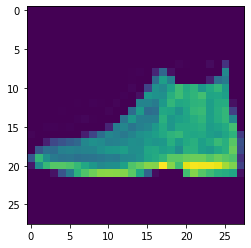

In [ ]:
x_test.T.reshape(-1,28,28)
from matplotlib import pyplot as plt
plt.imshow(x_test.T.reshape(-1,28,28)[0], interpolation='nearest')
plt.show()

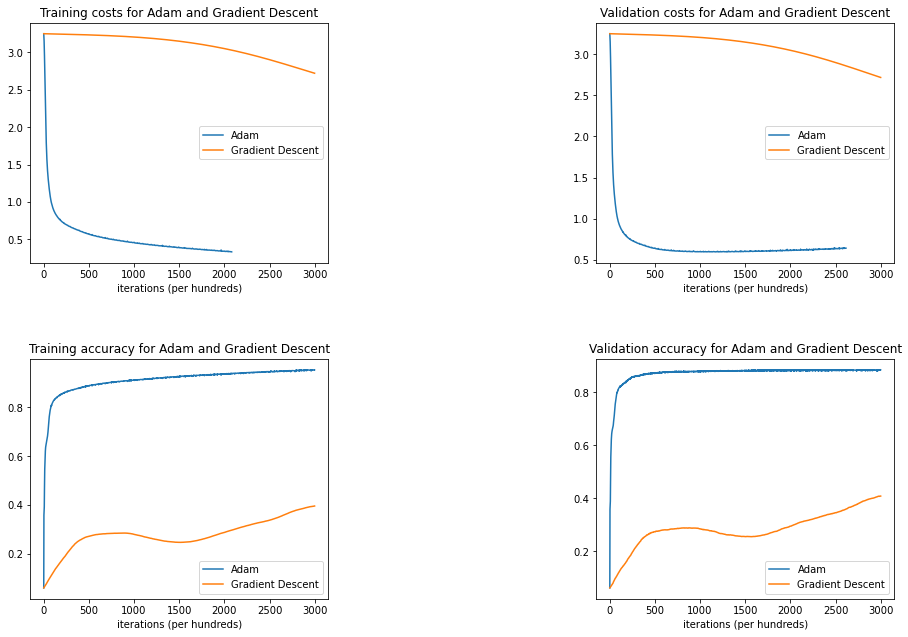

In [ ]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.4)
plt.subplot(2, 2, 1)
plt.plot(summaryA[0], label = "Adam")
plt.plot(summaryG[0], label = "Gradient Descent")
plt.xlabel('iterations (per hundreds)')
plt.title("Training costs for Adam and Gradient Descent" )
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(summaryA[2], label = "Adam")
plt.plot(summaryG[2], label = "Gradient Descent")
plt.xlabel('iterations (per hundreds)')
plt.title("Validation costs for Adam and Gradient Descent")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(summaryA[1], label = "Adam")
plt.plot(summaryG[1], label = "Gradient Descent")
plt.xlabel('iterations (per hundreds)')
plt.title("Training accuracy for Adam and Gradient Descent" )
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(summaryA[3], label = "Adam")
plt.plot(summaryG[3], label = "Gradient Descent")
plt.xlabel('iterations (per hundreds)')
plt.title("Validation accuracy for Adam and Gradient Descent")
plt.legend()

plt.show()


# Conclusion 1

As we can clearly see due the value of gradient descent dint improve after 40 % while the accuracy of adam is almost reaching 90 %, it is better to use a optimiser to achieve results in lesser time.

In [ ]:
def plotcrv(summaries,architecture, table):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    for i in range(0,len(architecture)):
        
        plt.subplot(2, 2, 1)
        plt.plot(np.squeeze(summaries[int(table.loc[table['Architecture'] == architecture[i]].index.values)][0]), label = architecture[i])
        plt.xlabel('iterations (per hundreds)')
        plt.title("Cost on training set")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(np.squeeze(summaries[int(table.loc[table['Architecture'] == architecture[i]].index.values)][2]), label = architecture[i])
        plt.xlabel('iterations (per hundreds)')
        plt.title("Cost on validation set" )
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(np.squeeze(summaries[int(table.loc[table['Architecture'] == architecture[i]].index.values)][1],), label = architecture[i])
        plt.xlabel('iterations (per hundreds)')
        plt.title("Accuracy on training set")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(np.squeeze(summaries[int(table.loc[table['Architecture'] == architecture[i]].index.values)][3]), label = architecture[i])
        plt.xlabel('iterations (per hundreds)')
        plt.title("Accuracy on validation set")
        plt.legend()
        
        
plt.show()        

## Neural network with one hidden layer

We are now going to test the NN with one hidden layer, we have taken relu and sigmoid with epoch of 1000 . we are going to run it for every activation layer in types tuple and for every layers in Layer tuple

we also have created a table and graphs for better visualization

In [ ]:
Layers = [ 34, 55, 89, 144]
types = ["relu", "sigmoid"]
epochs = 1000
summary = ()
Architecture = []
Train_cost = []
Train_acc = []
Val_cost = []
Val_acc = []
Test_acc = []
table1 = pd.DataFrame({
        'Architecture': [],
        'Train_cost':[],
        'Train_acc':[],
        'Val_cost':[],
        'Val_acc':[],
        'Test_acc':[]
        })
summaries1 = []
for activation in types:
    for non in Layers:
        parameters, summary = L_layer_model(x_train/255, y_train,x_val/255,y_val, layers_dims = [784,non,10],activation_functions = [activation],learning_rate = 1e-3, num_iterations = epochs,optimiser = "Adam" )
        p,test_acc, A,_ = predict(x_test, y_test,[activation], parameters)
        table1.loc[len(table1.index )] = [activation + "_" + str(non), summary[0][epochs - 1],summary[1][epochs - 1],summary[2][epochs - 1],summary[3][epochs - 1], test_acc]
        summaries1.append(summary)
table1
        
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_34,0.590009,0.88284,0.677020,0.8629,0.1001
1,relu_55,0.509997,0.90034,0.623094,0.8771,0.1001
2,relu_89,0.490133,0.90268,0.611694,0.8768,0.1008
3,relu_144,0.435783,0.91530,0.596956,0.8803,0.1017
4,sigmoid_34,0.728078,0.86480,0.764208,0.8504,0.8242
5,sigmoid_55,0.637952,0.87642,0.679169,0.8635,0.8332
6,sigmoid_89,0.588807,0.88424,0.640957,0.8696,0.8344
7,sigmoid_144,0.547228,0.89218,0.612242,0.8766,0.8323


From the above table to have a clearer image, we are choosing below architecture to plot a graph, there are as well paramaterized

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

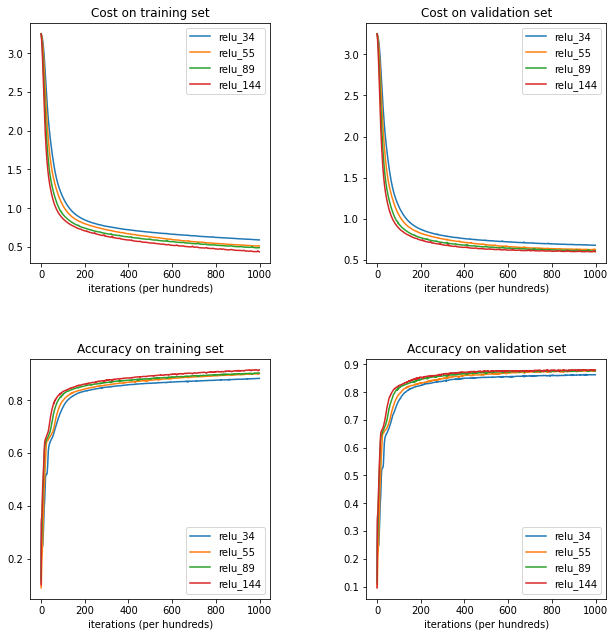

In [ ]:
architectures = ["relu_34","relu_55","relu_89","relu_144"]
plotcrv(summaries1, architectures,table1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

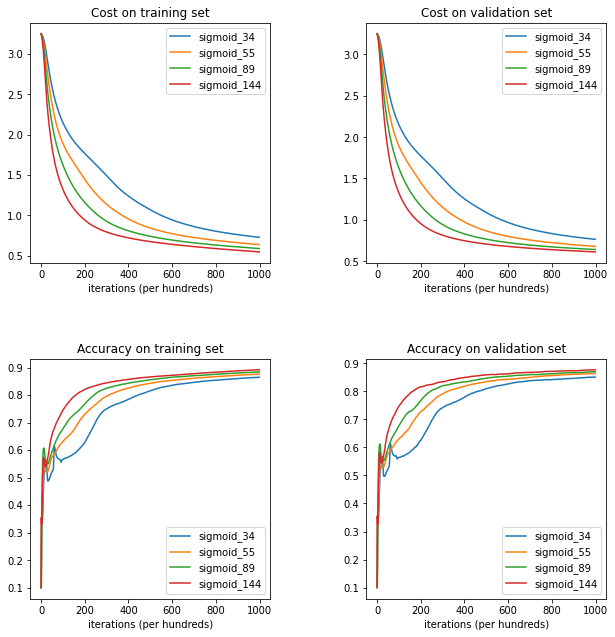

In [ ]:
architectures = ["sigmoid_34","sigmoid_55","sigmoid_89","sigmoid_144"]
plotcrv(summaries1, architectures,table1)

# Conclusions 


As we can infer from the table that when using one layer, the best fit with less error rate and minimum loss sigmoid-144 while relu had a huge loss percentage between training and testing data

## Neural network with two hidden layer


We are now going to test the NN with two hidden layer, we have taken relu and sigmoid with epoch of 800 . we are going to run it for every activation layer in types tuple and for every layers in Layer tuple

we also have created a table and graphs for better visualization

In [ ]:
def dif2nn(types,nons,epochs):
    summary = ()
    table = pd.DataFrame({
            'Architecture': [],
            'Train_cost':[],
            'Train_acc':[],
            'Val_cost':[],
            'Val_acc':[],
            'Test_acc':[]
            })
    summaries = []
    for activation in types:
        for non in nons:
            parameters, summary = L_layer_model(x_train/255, y_train,x_val/255,y_val, layers_dims = [784, non[0], non[1], 10],activation_functions = list(activation),learning_rate = 1e-3, num_iterations = epochs,optimiser = "Adam",early_stopping_metric = "acc", patience = epochs )
            p,test_acc, A,_ = predict(x_test/255, y_test,list(activation), parameters)
            table.loc[len(table.index )] = [activation[0] +"_"+ str(non[0]) + activation[1] +"_"+ str(non[1]), summary[0][epochs - 1],summary[1][epochs - 1],summary[2][epochs - 1],summary[3][epochs - 1], test_acc] 
            summaries.append(summary)

    return table,summaries

In [ ]:
nons = [(34, 55)]
types = [('relu', 'relu'), ('relu', 'sigmoid'),("sigmoid","relu"),('sigmoid',"sigmoid")]
table2,summaries2 = dif2nn(types,nons, epochs = 800)
table2       
        

,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_34relu_55,0.597899,0.88094,0.675440,0.8672,0.8557
1,relu_34sigmoid_55,0.605784,0.88244,0.664083,0.8685,0.8588
2,sigmoid_34relu_55,0.521285,0.89574,0.612198,0.8773,0.8662
3,sigmoid_34sigmoid_55,0.733897,0.86078,0.772393,0.8503,0.8397


# Conclusions 

we can infer from the table above that almost all of the architecture is giving a good accuracy , but validating the minimum loss , we can say that the combination of Sigmoid 34 and relu 55 has given us the best results 





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

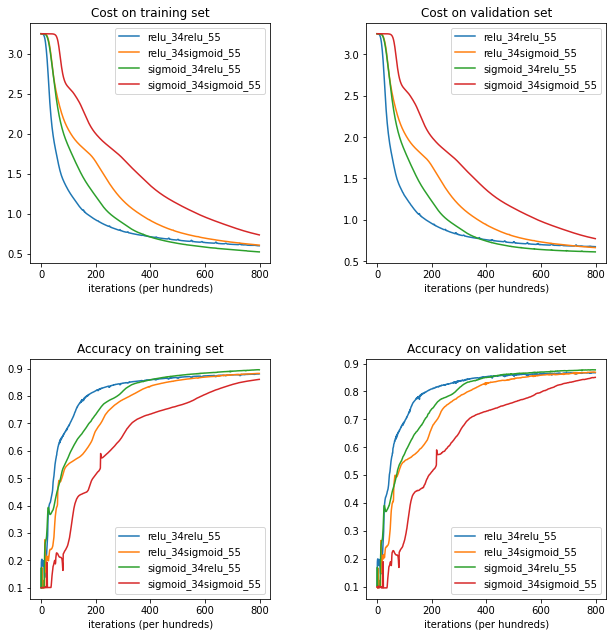

In [ ]:
architectures = ["relu_34relu_55","relu_34sigmoid_55","sigmoid_34relu_55","sigmoid_34sigmoid_55"]
plotcrv(summaries2, architectures,table2)

## Increasing the number of neurons in each layer

We are now going to test the NN with two hidden layer by increasing the number of neurons from 34-55 to 89-144, we have taken relu and sigmoid with epoch of 800 . we are going to run it for every activation layer in types tuple and for every layers in Layer tuple

we also have created a table and graphs for better visualization

In [ ]:
nons = [(89, 144)]
types = [('relu', 'relu'), ('relu', 'sigmoid'),("sigmoid","relu"),('sigmoid',"sigmoid")]
table3,summaries3 = dif2nn(types,nons, epochs = 800)
table3

,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_89relu_144,0.486207,0.90184,0.614497,0.8743,0.8688
1,relu_89sigmoid_144,0.504699,0.89924,0.594711,0.8796,0.8702
2,sigmoid_89relu_144,0.467509,0.90578,0.575294,0.8806,0.8750
3,sigmoid_89sigmoid_144,0.538297,0.89322,0.608211,0.8761,0.8666


# Conclusions 

we can infer from the table above that almost all of the architecture is giving a good accuracy , but validating the minimum loss , we can say that the combination of Sigmoid 89 and relu 144 has given us the best results 





In [ ]:
architectures = ["relu_89relu_144","relu_89sigmoid_144","sigmoid_89relu_144","sigmoid_89sigmoid_144"]
plotcrv(summaries3, architectures,table3)

# Increasing the number of neurons in each layer

We are now going to test the NN with two hidden layer by increasing the number of neurons from 89-144 to 610-987, we have taken relu and sigmoid with epoch of 100 . we are going to run it for every activation layer in types tuple and for every layers in Layer tuple

we also have created a table and graphs for better visualization

In [ ]:
nons = [(610, 987)]
types = [('relu', 'relu'), ('relu', 'sigmoid'),("sigmoid","relu"),('sigmoid',"sigmoid")]
table4,summaries4 = dif2nn(types,nons, epochs = 100)
table4  

,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_610relu_987,0.751427,0.84858,0.787493,0.8354,0.8289
1,relu_610sigmoid_987,0.825948,0.83164,0.841919,0.8228,0.8144
2,sigmoid_610relu_987,0.899737,0.81354,0.917125,0.8062,0.7998
3,sigmoid_610sigmoid_987,1.172977,0.74546,1.178421,0.7454,0.7433



# Conclusions 

we can infer from the table above that almost all of the architecture is giving a good accuracy but , but validating the minimum loss , we can say that the combination of Sigmoid 610 and relu 987 has given us the best results 
But we can also see that this is a hard choice as relu and relu combination is also giving us good results.

To conclude on this we need to run it for more epochs




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

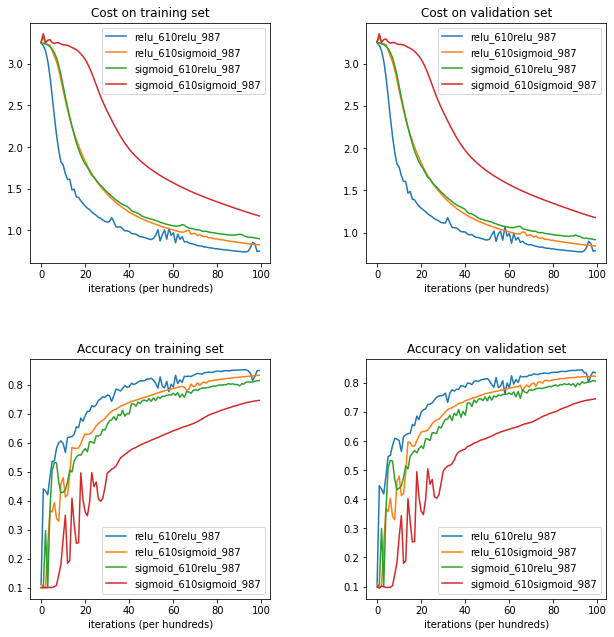

In [ ]:
architectures = ["relu_610relu_987","relu_610sigmoid_987","sigmoid_610relu_987","sigmoid_610sigmoid_987"]
plotcrv(summaries4, architectures,table4)

## Neural network with three hidden layer

In [ ]:
def dif3nn(types,nons,epochs):
    summary = ()
    table = pd.DataFrame({
            'Architecture': [],
            'Train_cost':[],
            'Train_acc':[],
            'Val_cost':[],
            'Val_acc':[],
            'Test_acc':[]
            })
    summaries = []
    for activation in types:
        for non in nons:
            parameters, summary = L_layer_model(x_train/255, y_train,x_val/255,y_val, layers_dims = [784, non[0], non[1],non[2], 10],activation_functions = list(activation),learning_rate = 1e-3, num_iterations = epochs,optimiser = "Adam",early_stopping_metric = "acc", patience = epochs )
            p,test_acc, A,_ = predict(x_test/255, y_test,list(activation), parameters)
            table.loc[len(table.index )] = [activation[0] +"_"+ str(non[0]) + activation[1] +"_"+ str(non[1]) + activation[2] +"_"+ str(non[2]), summary[0][epochs - 1],summary[1][epochs - 1],summary[2][epochs - 1],summary[3][epochs - 1], test_acc] 
            summaries.append(summary)

    return table,summaries

In [ ]:
nons = [(34,55,89)]
types = [('relu', 'relu',"relu"),('sigmoid', 'sigmoid',"sigmoid"), ('relu', 'relu',"sigmoid"),('sigmoid', 'sigmoid',"relu"),('relu', 'sigmoid',"relu"),('sigmoid', 'relu',"sigmoid")]
table5,summaries5 = dif3nn(types,nons, epochs = 600)
table5 

,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_34relu_55relu_89,0.707035,0.85634,0.790759,0.8391,0.8316
1,sigmoid_34sigmoid_55sigmoid_89,3.250801,0.10090,3.251017,0.0955,0.1000
2,relu_34relu_55sigmoid_89,0.779535,0.84878,0.814091,0.8407,0.8268
3,sigmoid_34sigmoid_55relu_89,0.852864,0.82596,0.895307,0.8168,0.8139
4,relu_34sigmoid_55relu_89,0.642431,0.87272,0.723600,0.8528,0.8505
5,sigmoid_34relu_55sigmoid_89,0.862131,0.82938,0.907236,0.8175,0.8142


# # Conclusions 

we can infer from the table above that almost all of the architecture is giving a good accuracy but , but validating the minimum loss , we can say that the combination of relu 634  sigmoid 55 and relu 89 has given us the best results 
But we can also see worst performing architecture is combinations of only sigmoid. so we can infer that we need to have a sandwich of both activation functions to achieve better results



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

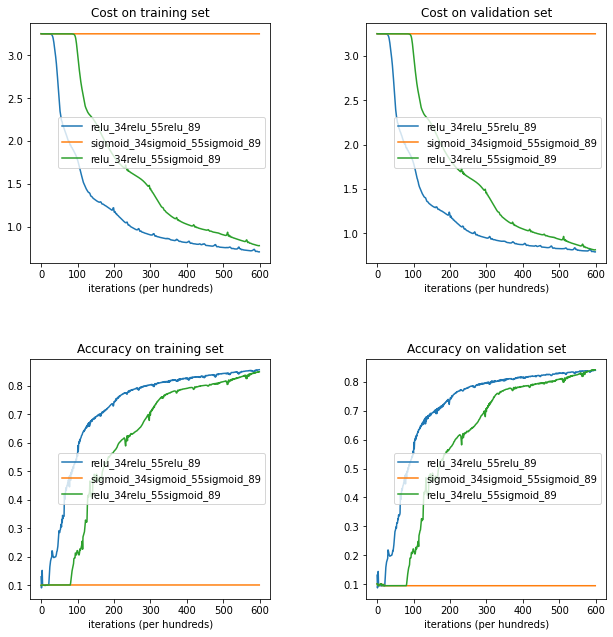

In [ ]:
architectures = ["relu_34relu_55relu_89","sigmoid_34sigmoid_55sigmoid_89","relu_34relu_55sigmoid_89"]
plotcrv(summaries5, architectures,table5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cu

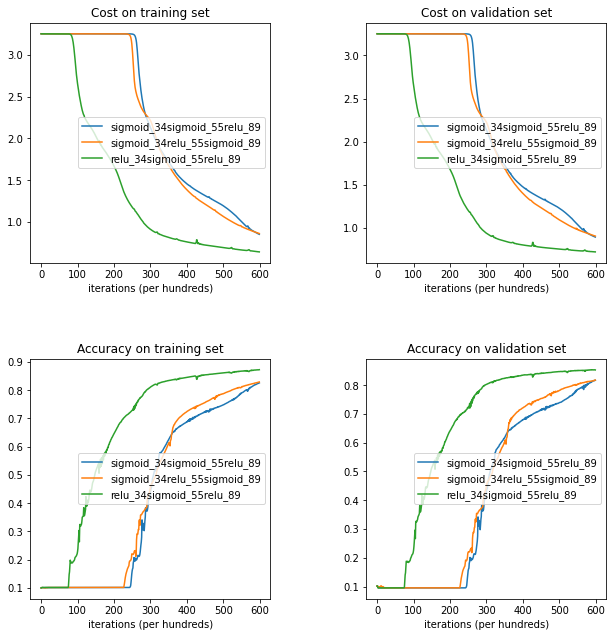

In [ ]:
architectures = ["sigmoid_34sigmoid_55relu_89","sigmoid_34relu_55sigmoid_89","relu_34sigmoid_55relu_89"]
plotcrv(summaries5, architectures,table5)

## Increasing the number of neurons

In [ ]:
nons = [(700,800,1000)]
types = [('relu', 'relu',"relu"), ('relu', 'relu',"sigmoid"),('sigmoid', 'sigmoid',"sigmoid")]
table6,summaries6 = dif3nn(types,nons, epochs = 100)
table6

,Architecture,Train_cost,Train_acc,Val_cost,Val_acc,Test_acc
0,relu_700relu_800relu_1000,0.898456,0.81158,0.920568,0.8093,0.8100
1,relu_700relu_800sigmoid_1000,1.025270,0.77846,1.041892,0.7779,0.7545
2,sigmoid_700sigmoid_800sigmoid_1000,2.517435,0.30808,2.520222,0.3023,0.3129


# Conclusions - 
we can see that relu relu relu has given the best performance with increased number of neurons, with sandwiching we have got a little less accuracy, but the worst of all the architecture is using only sigmoid

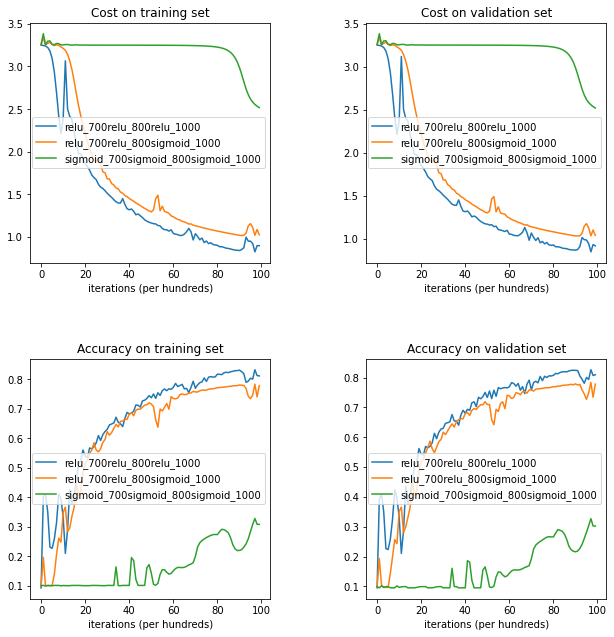

In [ ]:
architectures = ["relu_700relu_800relu_1000","relu_700relu_800sigmoid_1000","sigmoid_700sigmoid_800sigmoid_1000"]
plotcrv(summaries6, architectures,table6)